# Experiments 1 to 3 on simulated data.
**Authors:**
* José Ángel Martín-Baos
* Julio Alberto López-Gomez
* Luis Rodríguez-Benítez
* Tim Hillel
* Ricardo García-Ródenas

## Imports and function definitions

In [1]:
%load_ext autoreload
%autoreload 2

## Import packages
import pandas as pd  # For file input/output
from scipy import optimize
from scipy.optimize._numdiff import approx_derivative

import sys
import time
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Load common functions for the experiments
from expermients_functions import *

In [2]:
## Import the Classification models
from Models.MNL import MNL
from Models.SVM import SVM
from Models.RandomForest import RandomForest
from Models.XGBoost import XGBoost
from Models.NN import NN
from Models.DNN import DNN
#from Models.CNN import CNN
from Models.ResNet import ResNet

2022-09-19 17:41:57.521146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Customize matplotlib
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True, 
    "font.family": "serif",
    # Use 14pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}

plt.rcParams.update(tex_fonts)

## Experiment initialization

### Experiment parameters

In [4]:
## Experiment parameters
simulation_dir = "Data/Simulated/"
samples_subpath = "samples/"
adjusted_hyperparms_dir = "Data/adjusted-hyperparameters/SimulatedData/"
hyperparameters_file = "SimulatedData_hyperparameters"
crossval_dir = "Data/Simulated/crossval/"
reset_crossval_indices = 0 # Set to 0 for reproducibility of the experiment over multiple executions
partial_results_dir = "Data/Results-SimulatedDataset/"

recompute_Experiment_1 = False
recompute_Experiment_2 = False
recompute_Experiment_3 = False

rounding = 2
delta = 25e-3 # Delta parameter for numerical differentiation

mode_var = "y"
random_samples = 30
X_n_cols = 6
n_alternatives = 3
sample_size = 10000
lamb = np.sqrt(1/12)

variables_names = {0: ['a.0', 'b.0'],
                   1: ['a.1', 'b.1'],
                   2: ['a.2', 'b.2']}

# Read the simulation summary file and extract the different models
summary = pd.read_csv(simulation_dir + 'Summary.csv')
models = summary[["model", "function", "beta_a", "beta_b"]].drop_duplicates(keep='first', inplace=False)

CV = 5 # Number of cross-validation
n_iter = 1000 #  Number of iterations used on the random search
average_tech = "macro" #"micro"

hyperparameters_file = hyperparameters_file +'_'+ str(n_iter) + '.csv'

model_type_to_class = {"MNL": MNL,
                       "SVM": SVM,
                       "RF": RandomForest,
                       "XGBoost": XGBoost,
                       "NN": NN,
                       "DNN": DNN,
                       #"ResNet": ResNet,
                      }

STATIC_PARAMS = {'n_jobs': 12}

### Load the data

In [5]:
## Load the data
def load_data(model_number):
    sim = model_number * 30 
    model = models.loc[sim,:]
    model_info = summary.loc[sim, ["maximum_accuracy_train", "maximum_accuracy_test"]]

    train = pd.read_csv(simulation_dir + samples_subpath + summary.loc[sim, "name_train"])
    final_test = pd.read_csv(simulation_dir + samples_subpath + summary.loc[sim, "name_test"])
    final_test = final_test.head(final_test.shape[0]//10) # Take only 10% test data

    # Divide the dataset into charasteristics and target variable
    X = train.loc[:, train.columns != mode_var]
    y = train[mode_var]
    final_test_X = final_test.loc[:, final_test.columns != mode_var]
    final_test_y = final_test[mode_var]

    alts = list(y.unique()) # List containing al the modes (alternatives) in the dataset

    # Load the hyperparameters
    model_dir = "{}-{}-{}-{}/".format(model["model"],model["function"],model["beta_a"],model["beta_b"])
    try:
        adjusted_hyperparameters_file = pd.read_csv(adjusted_hyperparms_dir + model_dir + hyperparameters_file, index_col=0)
        hyperparameters = adjusted_hyperparameters_file.to_dict()
    except (OSError, IOError) as e:
        print("Error while loading best_hyperparameters for dataset {} - {}...".format(dataset_name, n_iter))
        pass

    return (sim, model, model_info, X, y, final_test_X, final_test_y, alts, hyperparameters)

In [6]:
## Pre-compute all the data for the experiments
def pre_compute_data(X):
    # Generate points where the probability will be computed
    X_for_prob = np.array([[0.25, 0.5, 0.75, 0.25, 0.5, 0.75]])
    deltas_vector = np.arange(-0.5,0.5+0.01, 0.01).reshape(-1,1)
    deltas = np.zeros((deltas_vector.shape[0], X_for_prob.shape[1]))
    deltas[:, 4] = deltas_vector[:,0]
    X_for_prob = X_for_prob + deltas
    X_for_prob_df = pd.DataFrame(X_for_prob, columns=X.columns)

    # Generate points where the probability will be computed (extrapolation)
    X_for_prob_extra = np.array([[0.25, 0.5, 0.75, 0.25, 0.5, 0.75]])
    deltas_vector = np.arange(-1,1+0.01, 0.01).reshape(-1,1)
    deltas = np.zeros((deltas_vector.shape[0], X_for_prob.shape[1]))
    deltas[:, 4] = deltas_vector[:,0]
    X_for_prob_extra = X_for_prob_extra + deltas
    X_for_prob_extra_df = pd.DataFrame(X_for_prob_extra, columns=X.columns)

    # Datasets for market shares
    X_plus_0_3, X_times_1_3 = X.copy(), X.copy()
    X_plus_0_3[['a.0', 'b.0']] = X_plus_0_3[['a.0', 'b.0']] + 0.3
    X_times_1_3[['a.0', 'b.0']] = X_times_1_3[['a.0', 'b.0']] * 1.3

    # Datasets for numerical differentiation 
    # Numerical differentiation for a.1
    X_a1_minus_d, X_a1_plus_d = X.copy(), X.copy()
    X_a1_minus_d['a.1'] = X_a1_minus_d['a.1'] - delta
    X_a1_plus_d['a.1'] = X_a1_plus_d['a.1'] + delta

    # Numerical differentiation for b.1
    X_b1_minus_d, X_b1_plus_d = X.copy(), X.copy()
    X_b1_minus_d['b.1'] = X_b1_minus_d['b.1'] - delta
    X_b1_plus_d['b.1'] = X_b1_plus_d['b.1'] + delta

    return (X_for_prob_df, X_for_prob_extra_df, X_plus_0_3, X_times_1_3, X_a1_minus_d, X_a1_plus_d, X_b1_minus_d, X_b1_plus_d)

In [7]:
## Create the classifier
def create_classifier(classifier, X, y, utility_function=None):
    integer_params = ['n_estimators', 'max_features', 'max_depth', 'min_samples_leaf', 'min_samples_split',
                    'hidden_layer_sizes', 'epochs', 'batch_size', 'min_child_weight', 'max_delta_step']
    choice_params = {"criterion": ["gini", "entropy"], # RF
                    "kernel":['rbf'], # SVM
                    "nystrom_components": [int(X.shape[0] * (CV - 1) / CV * 0.025)], # SVM
                    "learning_rate": ["adaptive"], # NN
                    "max_iter": [10000000], # NN
                    "tol": [1e-3], # NN
                    "input_dim": [X.shape[1]], # DNN, CNN, ResNet
                    "output_dim": [y.nunique()], # DNN, CNN, ResNet
                    "depth": [2,3,4,5,6,7,8,9,10], # DNN
                    "width": [25,50,100,150,200], # DNN, ResNet
                    "drop": [0.1, 0.01, 1e-5], # DNN, ResNet
                    "activation": ["tanh"], # NN
                    "solver": ["lbfgs","sgd","adam"], # NN
                    "batch_size": [128,256,512,1024], # NN, DNN, CNN, ResNet
                    "n_residual": [2,3,4], # ResNet
                    }

    # MNL
    beta_params = ["ASC_1", "ASC_2", "Beta_a", "Beta_b", "scale"]
    linear_utilities = {0: "Beta_a*a_0 + Beta_b*b_0",
                        1: "ASC_1 + Beta_a*a_1 + Beta_b*b_1",
                        2: "ASC_2 + Beta_a*a_2 + Beta_b*b_2"}
    CD_utilities = {0: "Power(a_0, Beta_a) * Power(b_0, Beta_b) * (scale +0.001)",
                    1: "Power(a_1, Beta_a) * Power(b_1, Beta_b) * scale",
                    2: "Power(a_2, Beta_a) * Power(b_2, Beta_b) * scale"}


    if classifier == "MNL":
        if utility_function == "linear":
            utility = linear_utilities
        elif utility_function == "CD":
            utility = linear_utilities
        else:
            raise ValueError("Unrecognized utility function {}".format(utility_function))
        base_clf = model_type_to_class[classifier](beta_params, utility)
    else:
        for k in list(hyperparameters[classifier].keys()):
            if k.startswith('_'):
                del hyperparameters[classifier][k]
                continue
            if np.isnan(hyperparameters[classifier][k]):
                del hyperparameters[classifier][k]
                continue
            if k in integer_params:
                hyperparameters[classifier][k] = int(hyperparameters[classifier][k])
            if k in choice_params.keys():
                hyperparameters[classifier][k] = choice_params[k][int(hyperparameters[classifier][k])]

        params = {**hyperparameters[classifier], **STATIC_PARAMS}
        base_clf = model_type_to_class[classifier](**params)
    
    return base_clf

## Experiment 1: Which is the best model?

In [9]:
def Experiment_1(train_scores_clf, test_scores_clf, X, y, final_test_X, final_test_y, clf, train_indices, test_indices):
    ## Applying k-Fold Cross Validation over training set
    loss = 0
    N_sum = 0
    for iteration in range(0, len(train_indices)):
        # Obtain training and testing data for this iteration (split of de k-Fold)
        X_train, X_test = X.loc[train_indices[iteration]], X.loc[test_indices[iteration]]
        y_train, y_test = y.loc[train_indices[iteration]], y.loc[test_indices[iteration]]

        time_ini = time.perf_counter()
        clf.fit(X_train, y_train)
        elapsed_time = time.perf_counter() - time_ini

        y_score = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        train_scores_clf[classifier][model_name]['Accuracy'] = np.append(train_scores_clf[classifier][model_name]['Accuracy'], accuracy_score(y_test, y_score)*100)
        train_scores_clf[classifier][model_name]['F1'] = np.append(train_scores_clf[classifier][model_name]['F1'], f1_score(y_test, y_score, average=average_tech)*100)
        train_scores_clf[classifier][model_name]['Recall'] = np.append(train_scores_clf[classifier][model_name]['Recall'], recall_score(y_test, y_score, average=average_tech)*100)
        train_scores_clf[classifier][model_name]['GMPCA'] = np.append(train_scores_clf[classifier][model_name]['GMPCA'], GMPCA(proba, y_test.values)*100)
        train_scores_clf[classifier][model_name]['Estimation time'] = np.append(train_scores_clf[classifier][model_name]['Estimation time'], elapsed_time)


    ## Out-of-sample results
    time_ini = time.perf_counter()
    clf.fit(X, y)
    elapsed_time = time.perf_counter() - time_ini
    y_score = clf.predict(final_test_X)
    proba = clf.predict_proba(final_test_X)

    test_scores_clf[classifier][model_name]['Accuracy'] = accuracy_score(final_test_y, y_score)*100
    test_scores_clf[classifier][model_name]['F1'] = f1_score(final_test_y, y_score, average=average_tech)*100
    test_scores_clf[classifier][model_name]['Recall'] = recall_score(final_test_y, y_score, average=average_tech)*100
    test_scores_clf[classifier][model_name]['GMPCA'] = GMPCA(proba, final_test_y.values)*100
    test_scores_clf[classifier][model_name]['Estimation time'] = elapsed_time

    return (train_scores_clf, test_scores_clf)

In [10]:
## Construct Experiment 1 Table
def construct_experiment_1_table(train_scores_clf, test_scores_clf):
    columns = ["Accuracy", "GMPCA"]

    # Compute the mean of all the stored results for all the models and construct the final table
    train_scores_df = {}
    test_scores_df = {}
    time_scores_df = {}
    train_scores_df["Maximum"] = pd.DataFrame(train_scores_clf["true"]).T["Accuracy"]
    test_scores_df["Maximum"] = pd.DataFrame(test_scores_clf["true"]).T["Accuracy"]

    train_scores_clf_mean = copy.deepcopy(train_scores_clf)
    for k_clf in model_type_to_class.keys():
        for k_model in train_scores_clf_mean[k_clf].keys():
            for k_score in train_scores_clf_mean[k_clf][k_model].keys():
                train_scores_clf_mean[k_clf][k_model][k_score] = np.round(np.mean(train_scores_clf_mean[k_clf][k_model][k_score]), rounding)

        train_scores_df[k_clf] = pd.DataFrame(train_scores_clf_mean[k_clf]).T[columns]
        test_scores_df[k_clf] = np.round(pd.DataFrame(test_scores_clf[k_clf]).T[columns], rounding)
        time_scores_df[k_clf] = np.round(pd.DataFrame(train_scores_clf_mean[k_clf]).T['Estimation time'], rounding)

    Experiment_1_table_train = pd.concat(train_scores_df, axis=1)
    Experiment_1_table_test = pd.concat(test_scores_df, axis=1)
    Experiment_1_table_time = pd.concat(time_scores_df, axis=1)

    return (Experiment_1_table_train, Experiment_1_table_test, Experiment_1_table_time)

## Experiment 2: How does each ML method compute the probabilities?

In [11]:
def actual_model_V(A, B, model):
    if model["function"] == "linear":
        V = model["beta_a"]*A + model["beta_b"]*B
    elif model["function"] == "CD":
        V = np.multiply(np.power(A, model["beta_a"]), np.power(B, model["beta_b"]))
    if model["model"] == "logit":
        V = V/lamb
    return V


def actual_probability(alt, proba_point, model):
    A = proba_point.iloc[:, proba_point.columns.str.startswith('a')].to_numpy()
    B = proba_point.iloc[:, proba_point.columns.str.startswith('b')].to_numpy()
    V = actual_model_V(A, B, model)
    if model["model"] == "logit":
        P = np.exp(V[:, alt]) / np.sum(np.exp(V), axis=1)
    elif model["model"] == "probit":
        N = 500000 # Number of simulations
        epsilon = np.random.normal(loc=0.0, scale=lamb, size=(N, V.shape[0], V.shape[1]))
        V_sim = V + epsilon
        choices_sim = np.argmax(V_sim, axis=2)
        P = np.sum(choices_sim == alt, axis=0)/N
    return P

In [12]:
def Experiment_2(X_for_prob, Experiment_2_actual_probabilities, Experiment_2_probabilities, dir="Figures/"):
    exp_2_alt = 1
    exp_2_var = 'b.1'
    exp_2_var_name = '$I_2$'

    # Graph colors
    cmap = plt.get_cmap("tab10") # Dark2, Accent, Set1, Set2, Set3, tab10

    # Logit models
    # Init plot
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14,8))
    for model_number in range(0,6): #12
        _, model, model_info, _, _, _, _, _, _ = load_data(model_number)
        i = model_number//3
        j = model_number%3
        axs[i,j].plot(X_for_prob[exp_2_var], Experiment_2_actual_probabilities[model_number], linewidth=2, color='k', label='Actual probability')

        color = 0
        for classifier in model_type_to_class.keys():
            axs[i,j].plot(X_for_prob[exp_2_var], Experiment_2_probabilities[model_number][classifier][:, exp_2_alt], color=cmap(color), alpha=0.85, label=classifier)
            color += 1

            plt.setp(axs[i, j], xlabel='$\\beta_I={}$'.format(model.beta_b))

        plt.setp(axs[i, 0], ylabel='{} utility'.format(model.function))

        #axs[i,j].set(aspect='equal', xlim=[0,1], ylim=[0,1])

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 1.1),
            fancybox=True, shadow=True, ncol=1)
    fig.text(0.5, 0.04, 'Value of the variable \'{}\''.format(exp_2_var_name), ha='center', va='center')
    fig.text(0.06, 0.5, 'Predicted probability of alt. \'{}\''.format(exp_2_alt + 1), ha='center', va='center', rotation='vertical')
    print("Logit error term")
    plt.show()
    fig.savefig(dir + "Experiment-2-logit.pdf", bbox_inches='tight')


    # Probit models
    # Init plot
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14,8))
    for model_number in range(6,12): #12
        _, model, model_info, _, _, _, _, _, _ = load_data(model_number)
        i = (model_number-6)//3
        j = (model_number-6)%3
        axs[i,j].plot(X_for_prob[exp_2_var], Experiment_2_actual_probabilities[model_number], linewidth=2, color='k', label='Actual probability')

        color = 0
        for classifier in model_type_to_class.keys():
            axs[i,j].plot(X_for_prob[exp_2_var], Experiment_2_probabilities[model_number][classifier][:, exp_2_alt], color=cmap(color), alpha=0.85, label=classifier)
            color += 1

            plt.setp(axs[i, j], xlabel='$\\beta_I={}$'.format(model.beta_b))

        plt.setp(axs[i, 0], ylabel='{} utility'.format(model.function))

        #axs[i,j].set(aspect='equal', xlim=[0,1], ylim=[0,1])

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 1.1),
            fancybox=True, shadow=True, ncol=1)
    fig.text(0.5, 0.04, 'Value of the variable \'{}\''.format(exp_2_var_name), ha='center', va='center')
    fig.text(0.06, 0.5, 'Predicted probability of alt. \'{}\''.format(exp_2_alt + 1), ha='center', va='center', rotation='vertical')
    print("Probit error term")
    plt.show()
    fig.savefig(dir + "Experiment-2-probit.pdf", bbox_inches='tight')

## Experiment 3: Behavioural analysis

### 3.1. Model extrapolation

In [15]:
def Experiment_3_extrapolation(X_for_prob_extra, Experiment_2_actual_probabilities_extra, Experiment_2_probabilities_extra, dir="Figures/"):
    exp_3_alt = 1
    exp_3_var = 'b.1'
    exp_3_var_name = '$I_2$'
    exp_3_models = [1,4]

    # Graph colors
    cmap = plt.get_cmap("tab10") # Dark2, Accent, Set1, Set2, Set3, tab10

    # Init plot
    fig, axs = plt.subplots(ncols=len(exp_3_models), nrows=1, figsize=(14,6))
    count = 0
    for model_number in exp_3_models:
        _, model, model_info, _, _, _, _, _, _ = load_data(model_number)
        axs[count].plot(X_for_prob_extra[exp_3_var], Experiment_2_actual_probabilities_extra[model_number], linewidth=2, color='k', label='Actual probability')

        color = 0
        for classifier in model_type_to_class.keys():
            axs[count].plot(X_for_prob_extra[exp_3_var], Experiment_2_probabilities_extra[model_number][classifier][:, exp_3_alt], color=cmap(color), alpha=0.85, label=classifier)
            color += 1

            plt.setp(axs[count], xlabel='$\\beta_I={}$'.format(model.beta_b))

        plt.setp(axs[count], ylabel='{} utility'.format(model.function))
        #axs[i,j].set(aspect='equal', xlim=[0,1], ylim=[0,1])
        count += 1

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
            fancybox=True, shadow=True, ncol=1)
    fig.text(0.5, 0.04, 'Value of the variable \'{}\''.format(exp_3_var_name), ha='center', va='center')
    fig.text(0.06, 0.5, 'Predicted probability of alt. \'{}\''.format(exp_3_alt + 1), ha='center', va='center', rotation='vertical')
    print("Experiment 3: Probabilities of the model for extrapolation")
    plt.show()
    fig.savefig(dir + "Experiment-3-extrapolation.pdf", bbox_inches='tight')

### 3.2. Market shares

In [16]:
def actual_market_shares():
    # The actual market shares have been calculated using simulation
    actual_market_shares_dict =  {
        'logit linear $\\beta_b=1.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [66.782, 16.609, 16.609],
            'Market_shares_S3': [50.045, 24.978, 24.978],
            },
        'logit linear $\\beta_b=2.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [68.695, 15.653, 15.653],
            'Market_shares_S3': [50.991, 24.504, 24.504],
            },
        'logit linear $\\beta_b=0.5$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [62.311, 18.845, 18.845],
            'Market_shares_S3': [47.821, 26.089, 26.089],
            },
        'logit CD $\\beta_b=1.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [60.962, 19.519, 19.519],
            'Market_shares_S3': [45.023, 27.489, 27.489],
            },
        'logit CD $\\beta_b=2.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [60.142, 19.929, 19.929],
            'Market_shares_S3': [45.586, 27.207, 27.207],
            },
        'logit CD $\\beta_b=0.5$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [60.107, 19.947, 19.947],
            'Market_shares_S3': [44.769, 27.615, 27.615],
            },
        'probit linear $\\beta_b=1.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [68.486, 15.757, 15.757],
            'Market_shares_S3': [50.885, 24.557, 24.557],
            },
        'probit linear $\\beta_b=2.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [69.768, 15.116, 15.116],
            'Market_shares_S3': [51.524, 24.238, 24.238],
            },
        'probit linear $\\beta_b=0.5$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [64.013, 17.993, 17.993],
            'Market_shares_S3': [48.773, 25.613, 25.613],
            },
        'probit CD $\\beta_b=1.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [62.567, 18.717, 18.717],
            'Market_shares_S3': [45.749, 27.126, 27.126],
            },
        'probit CD $\\beta_b=2.0$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [61.503, 19.249, 19.249],
            'Market_shares_S3': [46.207, 26.897, 26.897],
            },
        'probit CD $\\beta_b=0.5$': {
            'Market_shares_S1': [33.333, 33.333, 33.333],
            'Market_shares_S2': [61.745, 19.128, 19.128],
            'Market_shares_S3': [45.452, 27.274, 27.274],
            }, 
        }

    return actual_market_shares_dict

In [17]:
## Construct Experiment 3 Market Shares table
def construct_experiment_3_MS_table(behavioural_analysis_train):
    market_shares_df = {}

    for k_clf in model_type_to_class.keys():
        rows = pd.DataFrame()
        for k_model in behavioural_analysis_train[k_clf].keys():
            err = []
            scenarios = []
            for k_scenario in ['Market_shares_S1', 'Market_shares_S2', 'Market_shares_S3']:
                err.append(np.sum(np.abs(behavioural_analysis_train['true'][k_model][k_scenario] - \
                                behavioural_analysis_train[k_clf][k_model][k_scenario]))/n_alternatives)
                scenarios.append(k_scenario.replace("Market_shares_", ""))    
            rows = pd.concat([rows, pd.DataFrame([err], columns=scenarios, index=[k_model])], axis=0)
        market_shares_df[k_clf] = np.round(rows, rounding)

    Experiment_3_MS_table = pd.concat(market_shares_df, axis=1)

    return Experiment_3_MS_table


### 3.3. Willingness to Pay (WTP)

In [18]:
def Experiment_3_WTP(behavioural_analysis_train, dir="Figures/"):
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(12,16), dpi=300)

    for model_number in range(0,12): #12
        _, model, model_info, _, _, _, _, _, _ = load_data(model_number)
        model_name = model.model + ' ' + model.function + r' $\beta_b=' + str(model.beta_b) + '$'
        i = model_number//3
        j = model_number%3

        box_plot_data = []
        box_plot_labels = []
        quartile1 = []
        quartile3 = []
        for classifier in ['true'] + list(model_type_to_class.keys()):
            WTP = behavioural_analysis_train[classifier][model_name]['WTP_history']
            WTP = -1*WTP
            filtered_WTP = IQR(WTP, k=1.5)
            q1, med, q3 = np.percentile(filtered_WTP, [25, 50, 75])

            box_plot_data.append(filtered_WTP)
            if classifier == 'true':
                box_plot_labels.append('WTP')
            else:
                box_plot_labels.append(classifier)
            quartile1.append(q1)
            quartile3.append(q3)

        pos = list(range(len(box_plot_data),0,-1))
        axs[i,j].violinplot(box_plot_data, pos, widths=0.85, points=200, vert=False, showextrema=True, showmedians=True)

        axs[i,j].hlines(pos, quartile1, quartile3, color='steelblue', linestyle='-', lw=10, alpha=0.5)

        median = np.median(box_plot_data[0])
        axs[i,j].vlines(median, 0, 1, transform=axs[i,j].get_xaxis_transform(), color='k', linestyle='dotted', alpha=0.5)

        axs[i,j].set_ylim([0.4, len(box_plot_labels) + 0.6])
        #box_plot_labels = box_plot_labels + [''] # To assign empty labels to previous ticks
        box_plot_labels.reverse()
        axs[i,j].set_yticks(list(range(1,len(box_plot_labels)+1)))
        axs[i,j].set_yticklabels(box_plot_labels)
        
        plt.setp(axs[i,j], xlabel=model_name)


    print("Comparison of the WTP of the different models")
    fig.tight_layout()
    plt.show()
    fig.savefig(dir + "Experiment-3-WTP.pdf", bbox_inches='tight')


In [19]:
def Experiment_3_WTP_diff(behavioural_analysis_train, dir="Figures/"):
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(12,16), dpi=300) 

    for model_number in range(0,12): #12
        _, model, model_info, _, _, _, _, _, _ = load_data(model_number)
        model_name = model.model + ' ' + model.function + r' $\beta_b=' + str(model.beta_b) + '$'
        i = model_number//3
        j = model_number%3

        axs[i,j].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
        axs[i,j].set(
            axisbelow=True,  # Hide the grid behind plot objects
        )

        box_plot_data = []
        box_plot_labels = []
        for classifier in model_type_to_class.keys():
            WTP_diff = np.abs(behavioural_analysis_train[classifier][model_name]['WTP_history'] - behavioural_analysis_train['true'][model_name]['WTP_history'])
            # Remove invalid results
            filtered_WTP = WTP_diff[~np.isnan(WTP_diff)]
            filtered_WTP = filtered_WTP[np.abs(filtered_WTP) < 1e100]
            box_plot_data.append(filtered_WTP)
            box_plot_labels.append(classifier)

        axs[i,j].boxplot(box_plot_data, whis=1.5, showfliers=False)
        #axs[i,j].set_yscale('symlog')
        #axs[i,j].yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
        axs[i,j].set_xticklabels(labels=box_plot_labels, rotation=0, fontsize=8)
        
        plt.setp(axs[i,j], xlabel=model_name)

    #plt.setp(axs[i,0], ylabel='WTP difference')

    print("Difference in the WTP of the different models with respect to the actual WTP")
    fig.tight_layout()
    plt.show()
    fig.savefig(dir + "Experiment-3-WTP-diff.pdf", bbox_inches='tight')

In [20]:
## Construct Experiment 3 Willingness To Pay table
def construct_experiment_3_WTP_table(behavioural_analysis_train):
    WTP_df = []
    non_valid_percent = {}
    n_obs = 0
    for k_clf in ['true'] + list(model_type_to_class.keys()):
        rows = pd.DataFrame()
        non_valid_percent[k_clf] = 0
        for k_model in behavioural_analysis_train[k_clf].keys():
            WTP = behavioural_analysis_train[k_clf][k_model]['WTP']
            WTP = -1 * WTP
            rows = pd.concat([rows, pd.DataFrame(WTP, columns=[k_clf], index=[k_model])])
            if k_clf != 'true':
                non_valid_percent[k_clf] += behavioural_analysis_train[k_clf][k_model]['n_WTP_nan'] + behavioural_analysis_train[k_clf][k_model]['n_WTP_inf']
            n_obs += sample_size
        WTP_df.append(np.round(rows, rounding))
        non_valid_percent[k_clf] = non_valid_percent[k_clf] / n_obs * 100

    Experiment_3_WTP_table = pd.concat(WTP_df, axis=1)

    return (Experiment_3_WTP_table, non_valid_percent)

## Execute the experiments

In [25]:
## Execute experiments

## Initialize dictionaries to store partial results
# Load the previous experiment data (deserialize)
try:
    with open(partial_results_dir + '/train_scores_clf.pickle', 'rb') as handle:
        train_scores_clf = pickle.load(handle)
    with open(partial_results_dir + '/test_scores_clf.pickle', 'rb') as handle:
        test_scores_clf = pickle.load(handle)
except:
    train_scores_clf = {}
    test_scores_clf = {}

    train_scores_clf["true"] = {}
    test_scores_clf["true"] = {}

    for classifier in model_type_to_class.keys():
        train_scores_clf[classifier] = {}
        test_scores_clf[classifier] = {}
try:
    with open(partial_results_dir + '/Experiment_2_probabilities.pickle', 'rb') as handle:
        Experiment_2_probabilities = pickle.load(handle)
except:
    Experiment_2_probabilities = {}
    recompute_Experiment_2 = True
try:
    with open(partial_results_dir + '/Experiment_2_actual_probabilities.pickle', 'rb') as handle:
        Experiment_2_actual_probabilities = pickle.load(handle)
except:
    Experiment_2_actual_probabilities = {}
    recompute_Experiment_2 = True
try:
    with open(partial_results_dir + '/Experiment_2_probabilities_extra.pickle', 'rb') as handle:
        Experiment_2_probabilities_extra = pickle.load(handle)
except:
    Experiment_2_probabilities_extra = {}
    recompute_Experiment_2 = True
try:
    with open(partial_results_dir + '/Experiment_2_actual_probabilities_extra.pickle', 'rb') as handle:
        Experiment_2_actual_probabilities_extra = pickle.load(handle)
except:
    Experiment_2_actual_probabilities_extra = {}
    recompute_Experiment_2 = True
try:
    with open(partial_results_dir + '/behavioural_analysis_train.pickle', 'rb') as handle:
        behavioural_analysis_train = pickle.load(handle)
except:
    behavioural_analysis_train = {}
    recompute_Experiment_3 = True


if recompute_Experiment_3==True:
    # Fill actual results for Market Shares of the model (per alternative)
    behavioural_analysis_train["true"] = actual_market_shares()


# Iterate over all the simulated models
for model_number in range(0,12):
    # Load the data and the hyperparameters
    sim, model, model_info, X, y, final_test_X, final_test_y, alts, hyperparameters = load_data(model_number)
    model_name = model.model + ' ' + model.function + r' $\beta_b=' + str(model.beta_b) + '$'
    print("\n--- {}".format(model_name))

    # Pre-compute datasets
    X_for_prob, X_for_prob_extra, X_plus_0_3, X_times_1_3, X_a1_minus_d, X_a1_plus_d, X_b1_minus_d, X_b1_plus_d = pre_compute_data(X)

    # Obtain datasets for K-Fold cross validation (the same fold splits are used across all the iterations for all models)
    train_indices = []
    test_indices = []
    crossval_pickle_file = crossval_dir+summary.loc[sim, "name_train"].replace('.csv', '_crossval.pickle')
    try:
        train_indices, test_indices = pickle.load(open(crossval_pickle_file, "rb"))
        if reset_crossval_indices == 1: # Reset the indices
            raise FileNotFoundError
    except (OSError, IOError) as e:
        print("Recomputing Cross-val indices...")
        for (train_index, test_index) in StratifiedKFold(n_splits=CV).split(X, y):
            train_indices.append(train_index)
            test_indices.append(test_index)
        pickle.dump([train_indices, test_indices], open(crossval_pickle_file, "wb"))

    # Obtain true values for the dataset
    train_scores_clf["true"][model_name] = {}
    train_scores_clf["true"][model_name]['Accuracy'] = model_info.maximum_accuracy_train
    train_scores_clf["true"][model_name]['F1'] = None
    train_scores_clf["true"][model_name]['Recall'] = None
    train_scores_clf["true"][model_name]['GMPCA'] = None
    train_scores_clf["true"][model_name]['Estimation time'] = None

    test_scores_clf["true"][model_name] = {}
    test_scores_clf["true"][model_name]['Accuracy'] = model_info.maximum_accuracy_test
    test_scores_clf["true"][model_name]['F1'] = None
    test_scores_clf["true"][model_name]['Recall'] = None
    test_scores_clf["true"][model_name]['GMPCA'] = None
    test_scores_clf["true"][model_name]['Estimation time'] = None

    # Initialize Experiment 2 and compute the actual probabilities
    if recompute_Experiment_2==True or not (model_number in Experiment_2_actual_probabilities.keys()):
        Experiment_2_probabilities[model_number] = {}
        Experiment_2_probabilities_extra[model_number] = {}
        Experiment_2_actual_probabilities[model_number] = actual_probability(1, X_for_prob, model)
        Experiment_2_actual_probabilities_extra[model_number] = actual_probability(1, X_for_prob_extra, model)

    # Compute the actual WTP for this simulation
    if recompute_Experiment_3==True:
        if model.function == "linear":
            # WTP of the median of all observations
            behavioural_analysis_train["true"][model_name]["WTP"] = -model['beta_a']/model['beta_b']
            # History of the WTP values for all the observations
            behavioural_analysis_train["true"][model_name]["WTP_history"] = np.repeat(-model['beta_a']/model['beta_b'], X.shape[0])
        elif model.function == "CD":
            # Same WTP if we take the median of all the observations
            behavioural_analysis_train["true"][model_name]["WTP"] = -model['beta_a']/model['beta_b']
            # History of the WTP values for all the observations
            behavioural_analysis_train["true"][model_name]["WTP_history"] = -(model['beta_a']*X['b.1'].to_numpy())/(model['beta_b']*X['a.1'].to_numpy())

    # Iterate over all the classifiers
    for classifier in model_type_to_class.keys():
        print("\t--- {}".format(classifier))
        sys.stdout.flush()
        it_time_init = time.perf_counter()

        # Create the classifier
        clf = create_classifier(classifier, X, y, model.function)
        fitted = False

        # Create dictionary to store the results
        if not classifier in train_scores_clf.keys():
            train_scores_clf[classifier] = {}
        if not classifier in test_scores_clf.keys():
            test_scores_clf[classifier] = {}

        if recompute_Experiment_1==True or not (model_name in train_scores_clf[classifier].keys()) or not (model_name in test_scores_clf[classifier].keys()):
            # Create dictionary to store the results for the selected classifier
            train_scores_clf[classifier][model_name] = {}
            train_scores_clf[classifier][model_name]['Accuracy'] = []
            train_scores_clf[classifier][model_name]['F1'] = []
            train_scores_clf[classifier][model_name]['Recall'] = []
            train_scores_clf[classifier][model_name]['GMPCA'] = []
            train_scores_clf[classifier][model_name]['Estimation time'] = []

            test_scores_clf[classifier][model_name] = {}
            test_scores_clf[classifier][model_name]['Accuracy'] = []
            test_scores_clf[classifier][model_name]['F1'] = []
            test_scores_clf[classifier][model_name]['Recall'] = []
            test_scores_clf[classifier][model_name]['GMPCA'] = []
            test_scores_clf[classifier][model_name]['Estimation time'] = []
            
            # Experiment 1: Model accuracy
            train_scores_clf, test_scores_clf = Experiment_1(train_scores_clf, test_scores_clf, 
                X, y, final_test_X, final_test_y, clf, train_indices, test_indices)

            # Store the partial experiment data (serialize)
            with open(partial_results_dir + '/train_scores_clf.pickle', 'wb') as handle:
                pickle.dump(train_scores_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(partial_results_dir + '/test_scores_clf.pickle', 'wb') as handle:
                pickle.dump(test_scores_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)


        # Experiment 2: Model probabilities
        if recompute_Experiment_2==True or not (classifier in Experiment_2_probabilities[model_number].keys()):
            if fitted == False:
                # Fit the classifier on training set for Experiments 2 and 3
                clf.fit(X, y)
                fitted = True
                
            Experiment_2_probabilities[model_number][classifier] = clf.predict_proba(X_for_prob)
            Experiment_2_probabilities_extra[model_number][classifier] = clf.predict_proba(X_for_prob_extra)

            # Store the partial experiment data (serialize)
            with open(partial_results_dir + '/Experiment_2_probabilities.pickle', 'wb') as handle:
                pickle.dump(Experiment_2_probabilities, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(partial_results_dir + '/Experiment_2_actual_probabilities.pickle', 'wb') as handle:
                pickle.dump(Experiment_2_actual_probabilities, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(partial_results_dir + '/Experiment_2_probabilities_extra.pickle', 'wb') as handle:
                pickle.dump(Experiment_2_probabilities_extra, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(partial_results_dir + '/Experiment_2_actual_probabilities_extra.pickle', 'wb') as handle:
                pickle.dump(Experiment_2_actual_probabilities_extra, handle, protocol=pickle.HIGHEST_PROTOCOL)


        # Experiment 3: Market shares and Willingness to pay
        if recompute_Experiment_3==True or not (classifier in behavioural_analysis_train.keys()):
            if fitted == False:
                # Fit the classifier on training set for Experiments 2 and 3
                clf.fit(X, y)
                fitted = True

            exp_3_WTP_alt = 1

            if classifier not in behavioural_analysis_train.keys():
                behavioural_analysis_train[classifier] = {}

            behavioural_analysis_train[classifier][model_name] = {}

            behavioural_analysis_train[classifier][model_name]["Market_shares_S1"] = \
                np.round(np.sum(clf.predict_proba(X), axis=0)/X.shape[0] * 100, 3)
            behavioural_analysis_train[classifier][model_name]["Market_shares_S2"] = \
                np.round(np.sum(clf.predict_proba(X_plus_0_3), axis=0)/X_plus_0_3.shape[0] * 100, 3)
            behavioural_analysis_train[classifier][model_name]["Market_shares_S3"] = \
                np.round(np.sum(clf.predict_proba(X_times_1_3), axis=0)/X_times_1_3.shape[0] * 100, 3)


            # Compute the WTP for alternative 1:
            # Get the matrices of probabilities for this WTP point and subtract them,
            # then, divide the result by the increment in X
            inc_X = (X_a1_plus_d - X_a1_minus_d)['a.1'][0]
            D0 = (clf.predict_proba(X_a1_plus_d) - clf.predict_proba(X_a1_minus_d)) / inc_X
            D1 = (clf.predict_proba(X_b1_plus_d) - clf.predict_proba(X_b1_minus_d)) / inc_X

            # Extract the derivative of the desired alternative
            d0 = D0[:, exp_3_WTP_alt]
            d1 = D1[:, exp_3_WTP_alt]
            WTP = -d0/d1

            # Remove invalid results
            filtered_WTP = WTP[~np.isnan(WTP)]
            filtered_WTP = filtered_WTP[np.abs(filtered_WTP) < 1e100]
            behavioural_analysis_train[classifier][model_name]["n_WTP_nan"] = np.sum(np.isnan(WTP))
            behavioural_analysis_train[classifier][model_name]["n_WTP_inf"] = np.sum(np.abs(WTP) >= 1e100)

            # Store the WTP
            behavioural_analysis_train[classifier][model_name]["WTP_history"] = WTP
            
            # Store the median of the WTP over all the samples
            behavioural_analysis_train[classifier][model_name]["WTP"] = np.median(filtered_WTP)

            # Store the partial experiment data (serialize)
            with open(partial_results_dir + '/behavioural_analysis_train.pickle', 'wb') as handle:
                pickle.dump(behavioural_analysis_train, handle, protocol=pickle.HIGHEST_PROTOCOL)


        print("\t    + Elapsed: {} seconds".format(np.round(time.perf_counter()-it_time_init), 2))

        


--- logit linear $\beta_b=1.0$
	--- MNL
	    + Elapsed: 0.0 seconds
	--- SVM
	    + Elapsed: 0.0 seconds
	--- RF
	    + Elapsed: 0.0 seconds
	--- XGBoost
	    + Elapsed: 0.0 seconds
	--- NN
	    + Elapsed: 0.0 seconds
	--- DNN
	    + Elapsed: 0.0 seconds

--- logit linear $\beta_b=2.0$
	--- MNL
	    + Elapsed: 0.0 seconds
	--- SVM
	    + Elapsed: 0.0 seconds
	--- RF
	    + Elapsed: 0.0 seconds
	--- XGBoost
	    + Elapsed: 0.0 seconds
	--- NN
	    + Elapsed: 0.0 seconds
	--- DNN
	    + Elapsed: 0.0 seconds

--- logit linear $\beta_b=0.5$
	--- MNL
	    + Elapsed: 0.0 seconds
	--- SVM
	    + Elapsed: 0.0 seconds
	--- RF
	    + Elapsed: 0.0 seconds
	--- XGBoost
	    + Elapsed: 0.0 seconds
	--- NN
	    + Elapsed: 0.0 seconds
	--- DNN
	    + Elapsed: 0.0 seconds

--- logit CD $\beta_b=1.0$
	--- MNL
	    + Elapsed: 0.0 seconds
	--- SVM
	    + Elapsed: 0.0 seconds
	--- RF
	    + Elapsed: 0.0 seconds
	--- XGBoost
	    + Elapsed: 0.0 seconds
	--- NN
	    + Elapsed: 0.0 seconds
	--- DNN
	    + E

## Export LaTeX tables/figures

In [26]:
# Obtain Experiment 1 Tables: Accuracy
Experiment_1_table_train, Experiment_1_table_test, Experiment_1_table_time = construct_experiment_1_table(train_scores_clf, test_scores_clf)
Experiment_1_table_time = pd.DataFrame(np.round(Experiment_1_table_time.mean(axis=0), rounding), columns=['Avg. estimation time (seconds)']).T

# Obtain Experiment 3 Tables: Market shares y willingness to pay
Experiment_3_MS_table = construct_experiment_3_MS_table(behavioural_analysis_train)
Experiment_3_WTP_table, non_valid_percent = construct_experiment_3_WTP_table(behavioural_analysis_train)

print(non_valid_percent)

{'true': 0.0, 'MNL': 0.0025, 'SVM': 0.0, 'RF': 1.006875, 'XGBoost': 0.03733333333333333, 'NN': 0.0008333333333333334, 'DNN': 0.0007142857142857143}


In [27]:
## Export tables as latex code

# Experiment 1
pandas_to_latex(Experiment_1_table_train, 'Latex_tables/experiment_1_train.tex', align_rest='l', index = True, multicolumn=True, midrule_jump=[0], fit_width=True, caption="Accuracy and GMPCA results by model for each synthetic dataset on the training set (using 5-CV)", label="tab:experiment-1-train")
pandas_to_latex(Experiment_1_table_test, 'Latex_tables/experiment_1_test.tex', align_rest='l', index = True, multicolumn=True, midrule_jump=[0], fit_width=True, caption="Accuracy and GMPCA results by model for each synthetic dataset on the test set", label="tab:experiment-1-test")
pandas_to_latex(Experiment_1_table_time, 'Latex_tables/experiment_1_time.tex', align_rest='l', index = True, fit_width=True, caption="Average estimation time by model on the synthetic datasets", label="tab:experiment-1-time")

# Experiment 3
pandas_to_latex(Experiment_3_MS_table, 'Latex_tables/experiment_3_MS_table.tex', align_rest='l', index = True, multicolumn=True, fit_width=True, caption="Average error of the estimated market shares by model on the synthetic datasets", label="tab:experiment_3_MS_table")
pandas_to_latex(Experiment_3_WTP_table, 'Latex_tables/experiment_3_WTP_table.tex', align_rest='l', index = True, multicolumn=False, fit_width=True, caption="Estimated WTP by model on the synthetic datasets", label="tab:experiment_3_WTP_table")


Logit error term


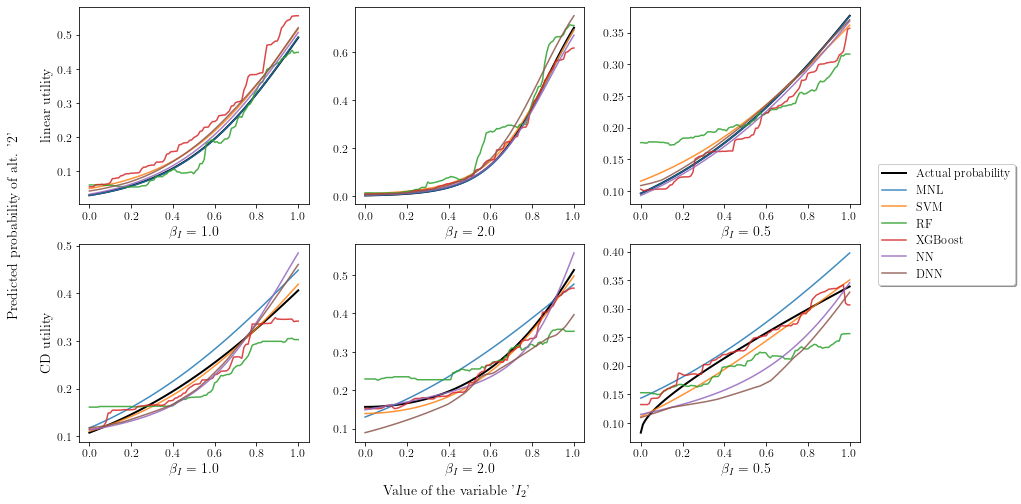

Probit error term


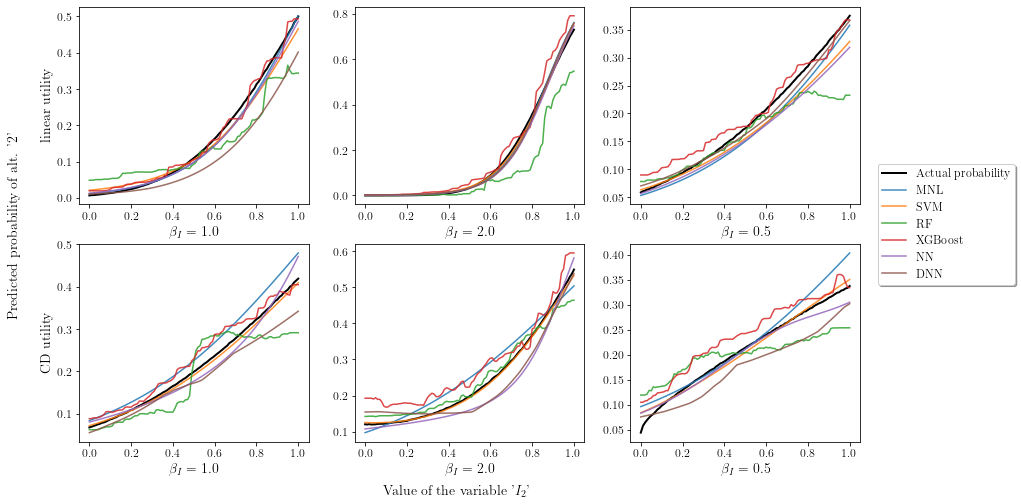

--------------------------------------------------------------------------------
Experiment 3: Probabilities of the model for extrapolation


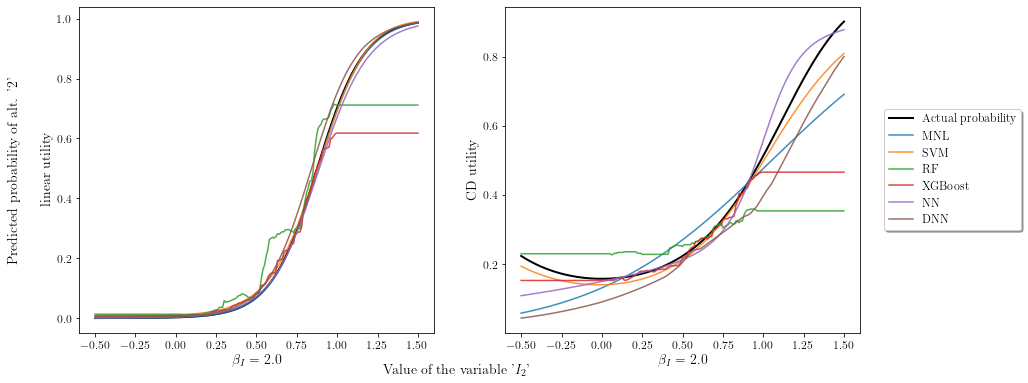

--------------------------------------------------------------------------------
Difference in the WTP of the different models with respect to the actual WTP


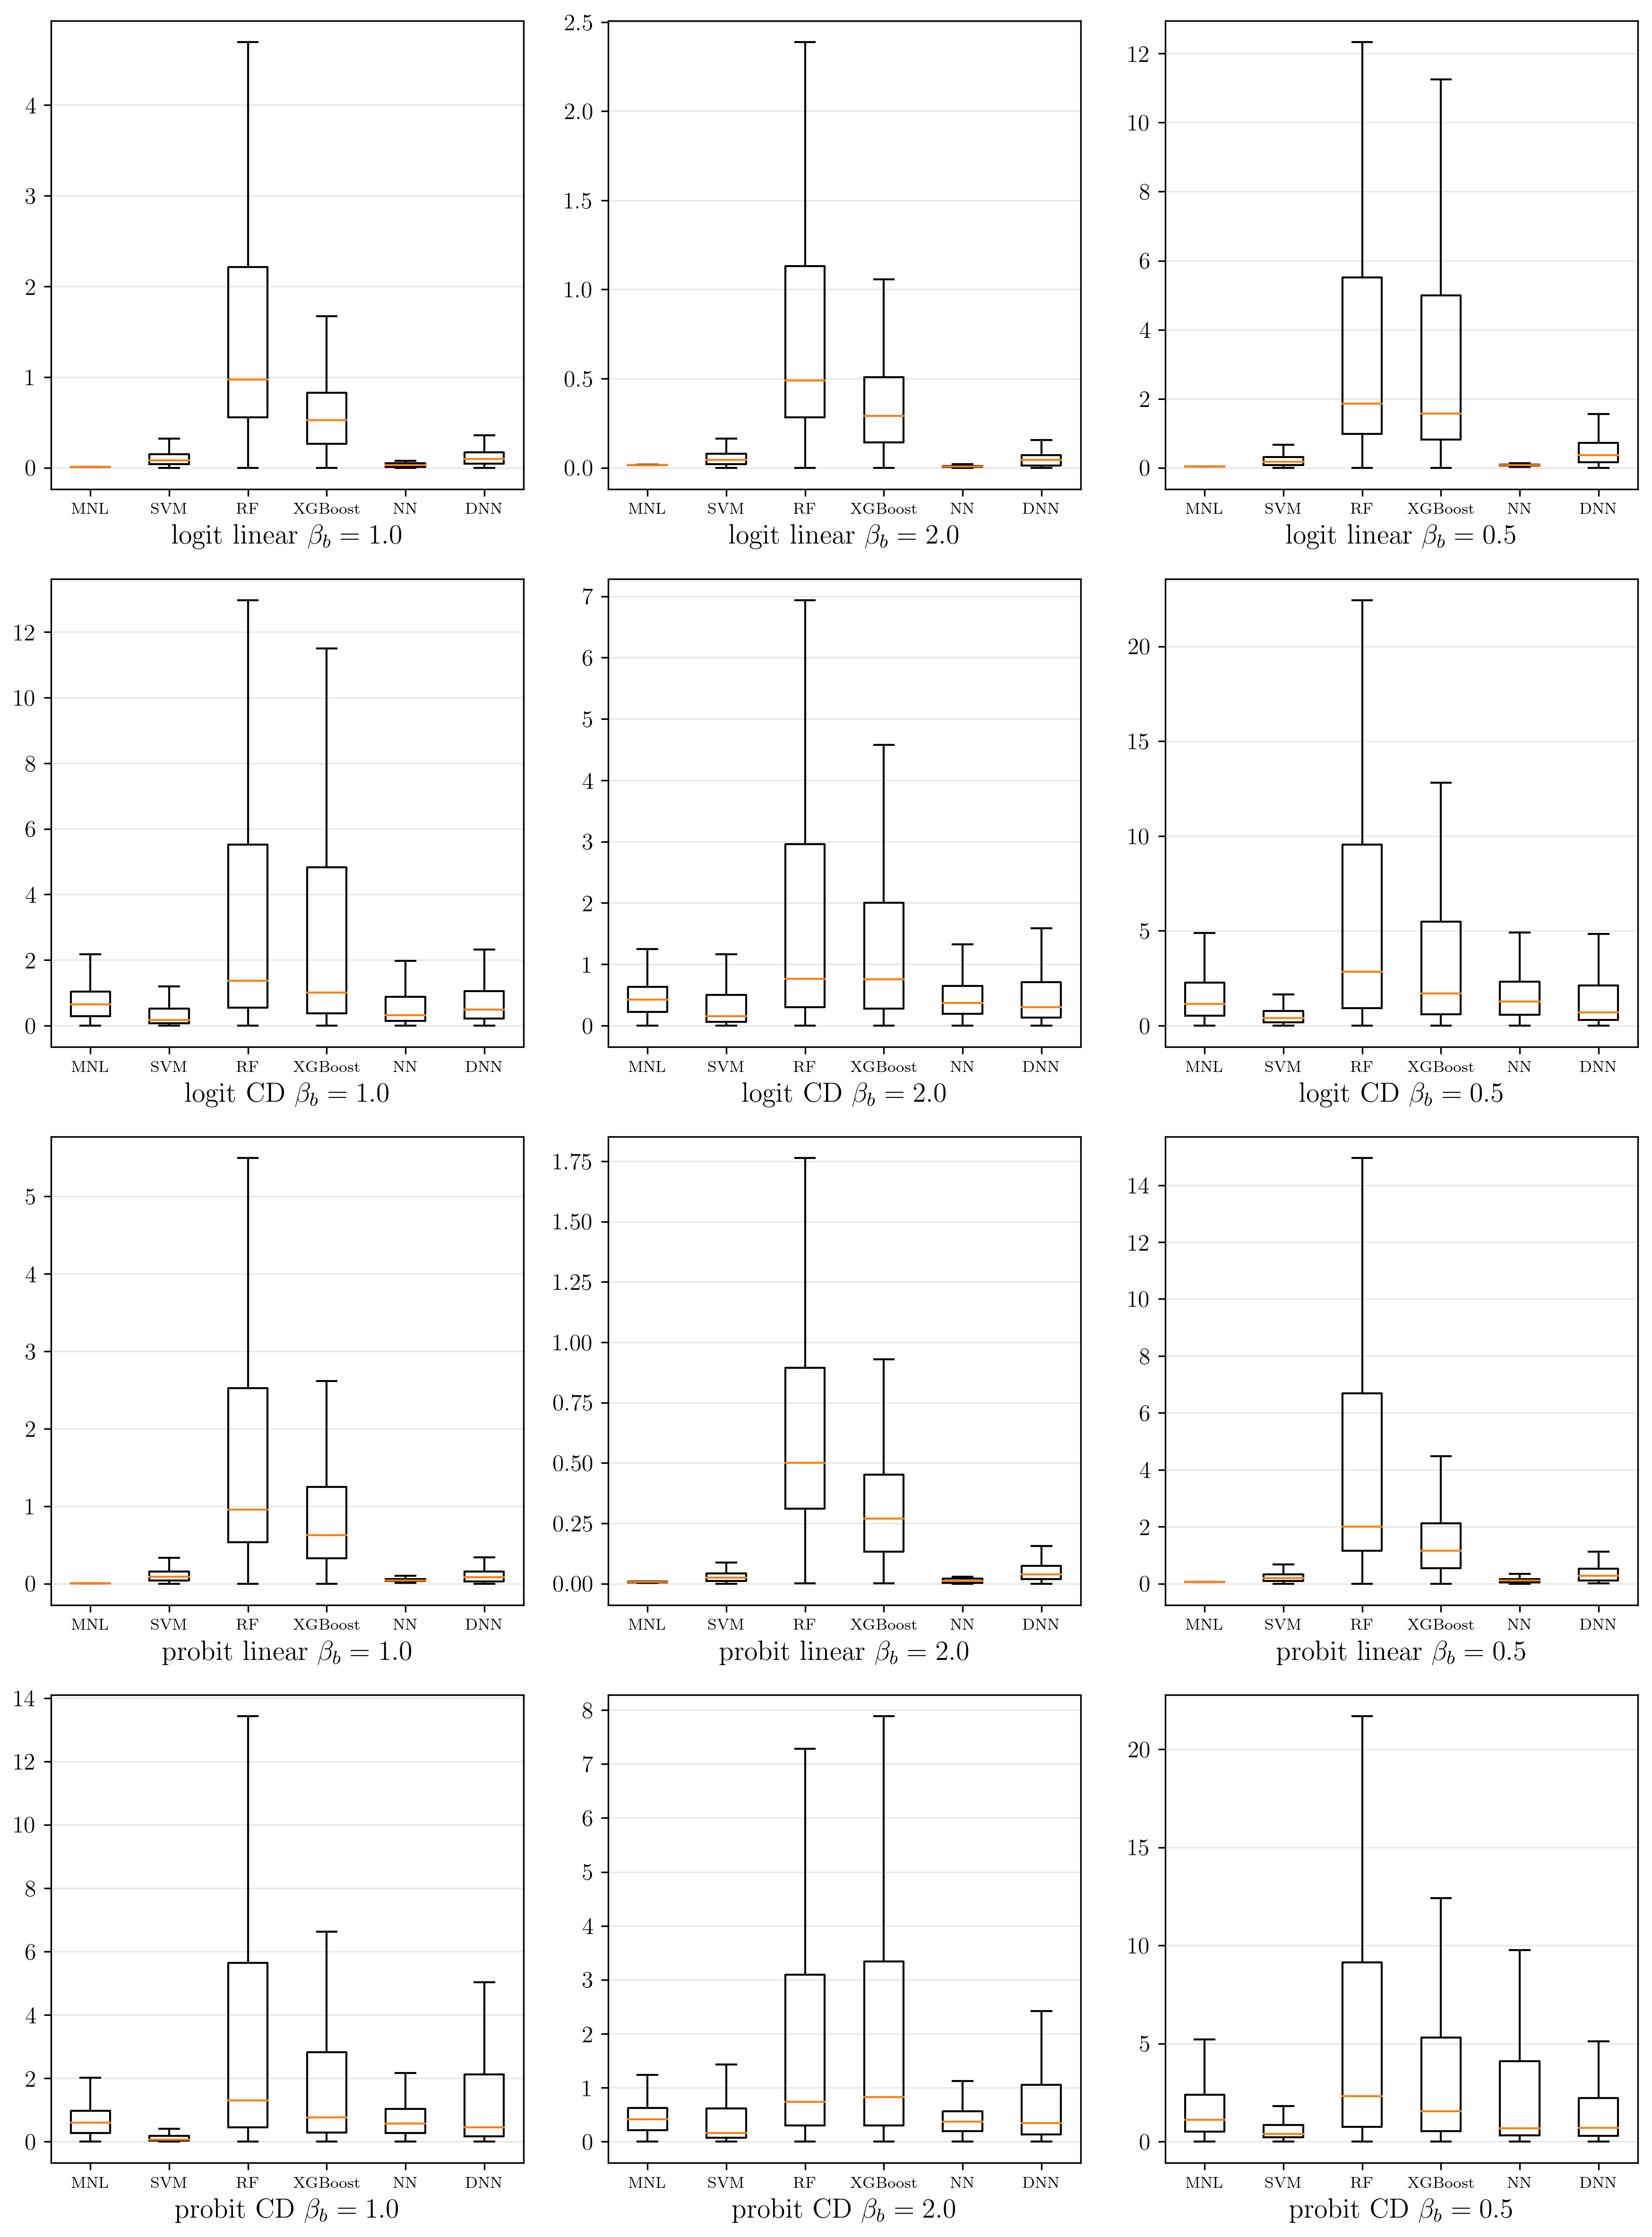

Comparison of the WTP of the different models


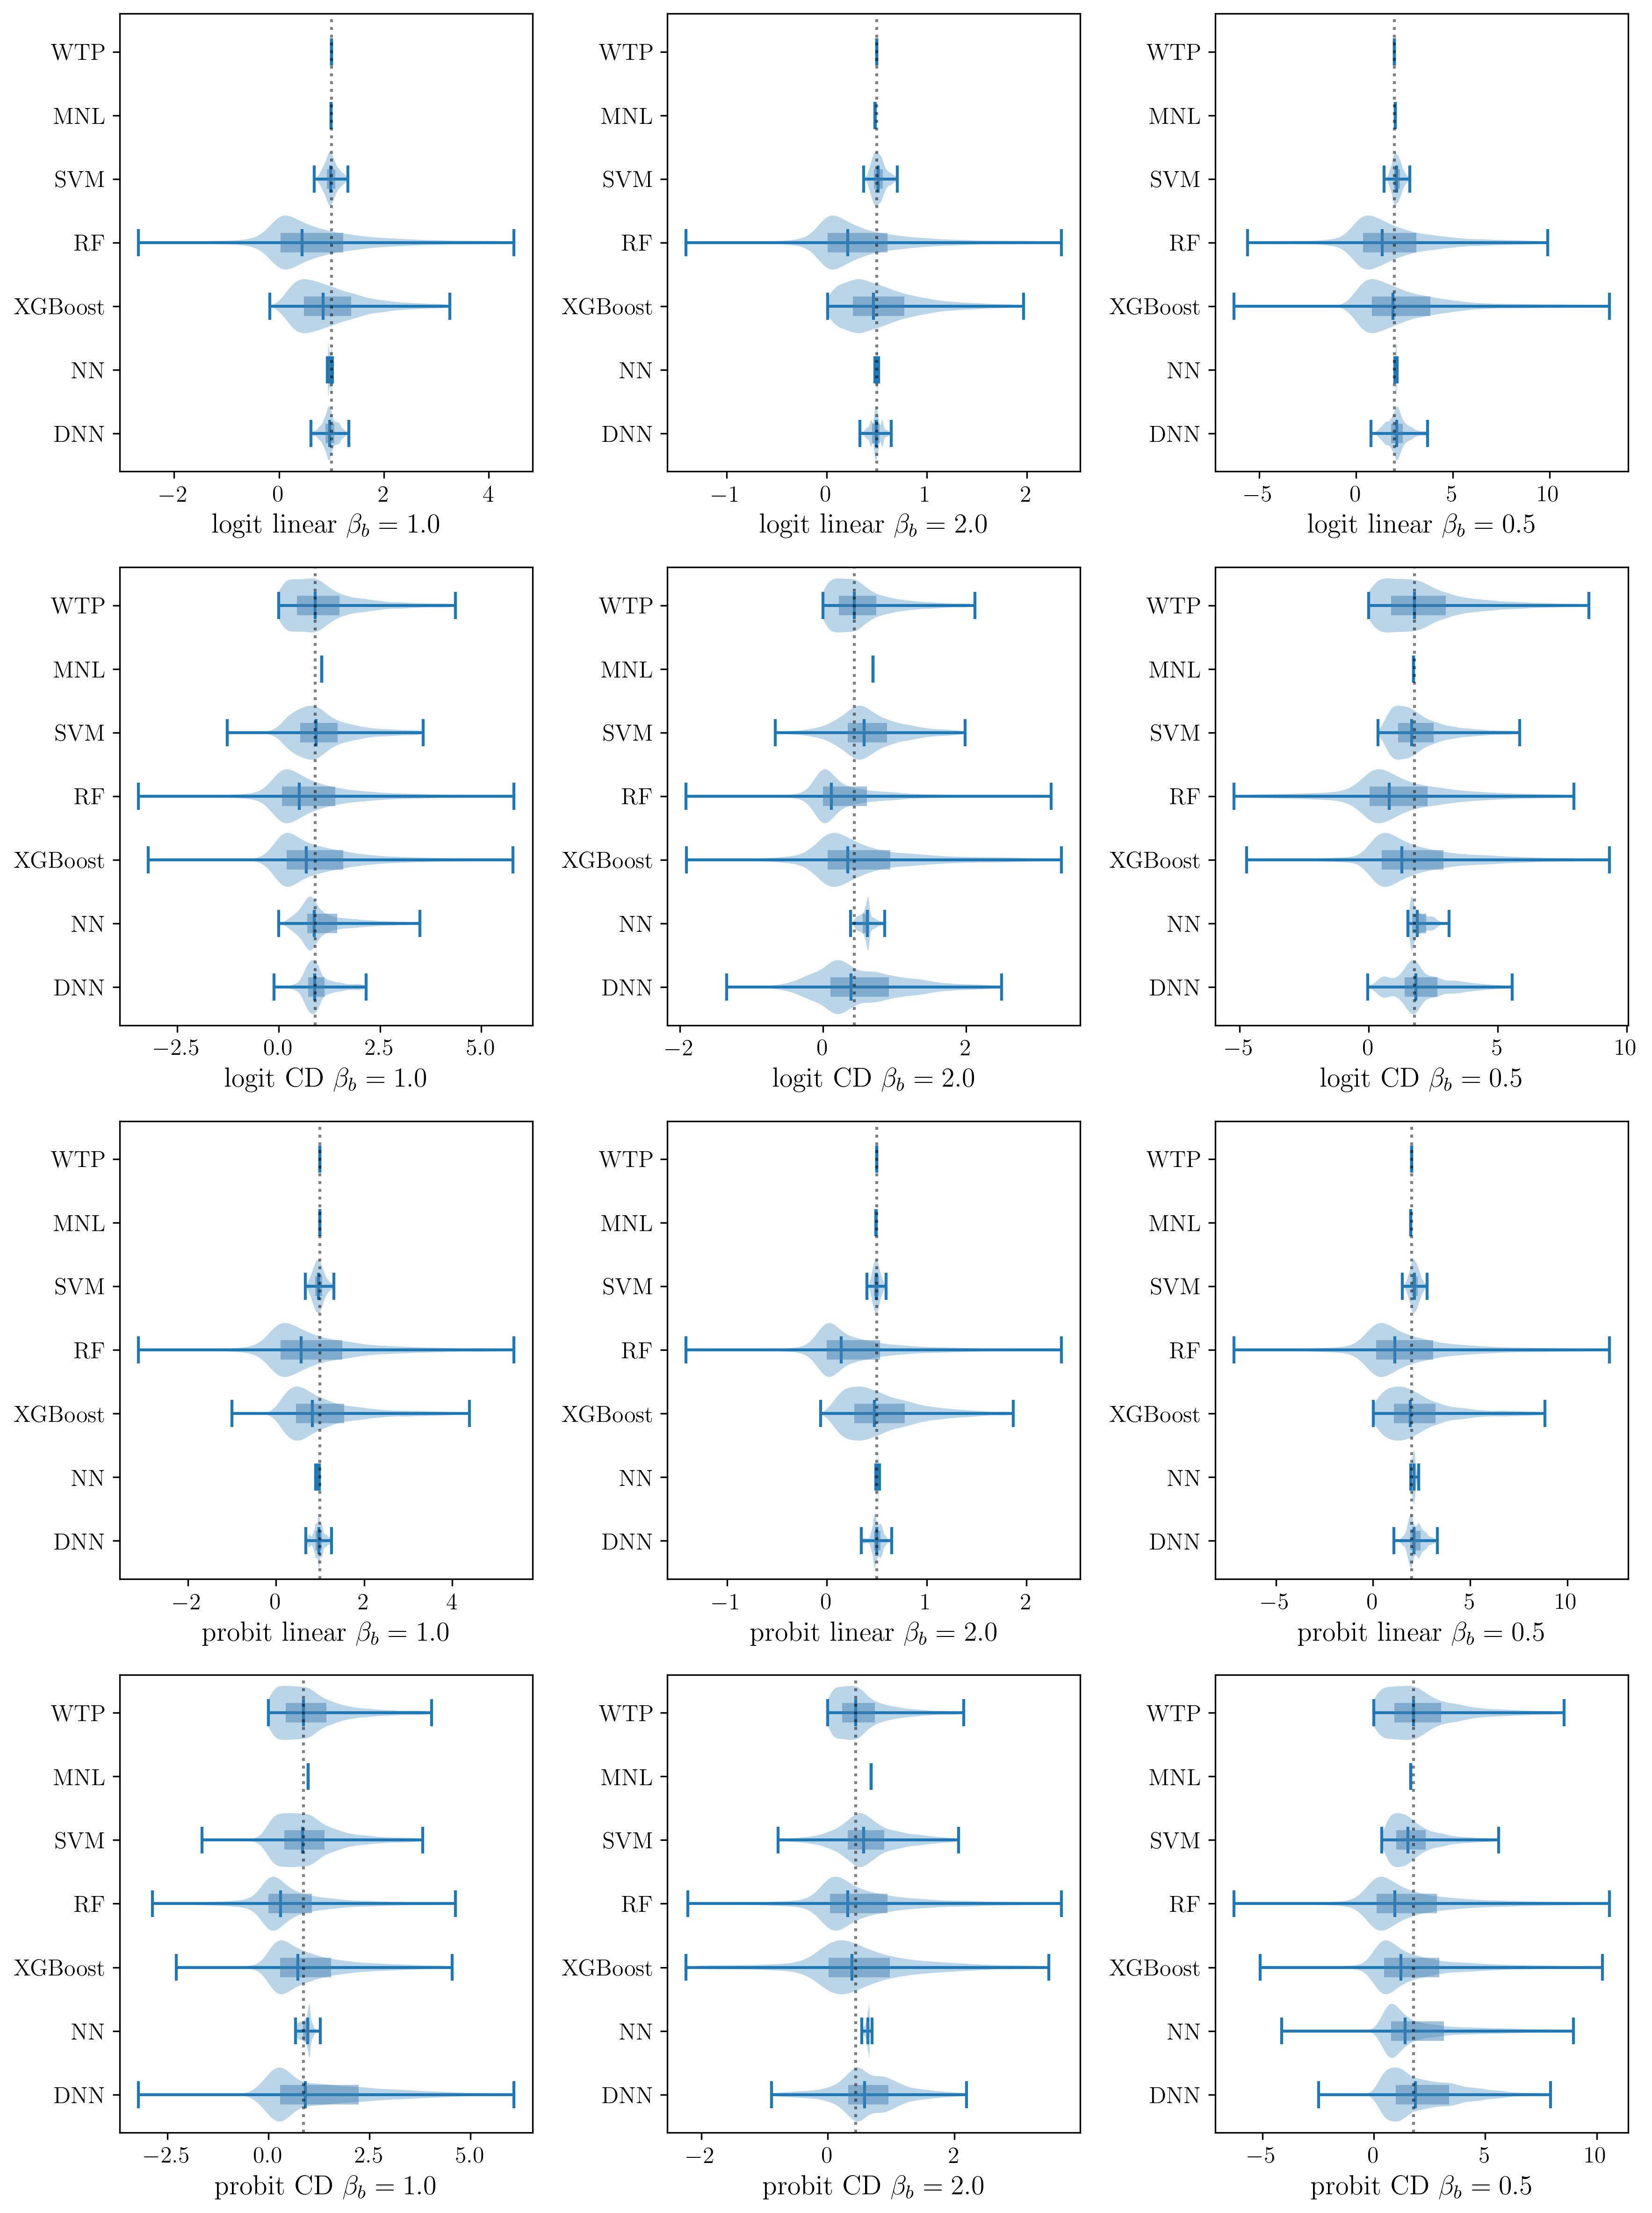

In [28]:
## Export figures

# Experiment 2
Experiment_2(X_for_prob, Experiment_2_actual_probabilities, Experiment_2_probabilities, dir="Figures/")

print("-"*80)

# Experiment 3
Experiment_3_extrapolation(X_for_prob_extra, Experiment_2_actual_probabilities_extra, Experiment_2_probabilities_extra, dir="Figures/")
print("-"*80)
Experiment_3_WTP_diff(behavioural_analysis_train, dir="Figures/")
Experiment_3_WTP(behavioural_analysis_train, dir="Figures/")